# Loading Packages & Initialization

reference : https://gist.github.com/mertedali/ab7078b9c29dea18c72525239d636b96

In [2]:
rm(list=ls())

library(data.table)
library(tidyverse)
library(rJava)
library(RNetLogo)

library(lhs) # For maximin Latin hypercube sampling
library(ggplot2)
library(caret)
library(randomForest)
library(factoextra)
library(e1071)
library(TSrepr) # for evaluating predictive power

options(warn = -1)

In [5]:
# Select if data generation is wanted
GenerateTTData <- 1

In [4]:
Is_Headless <- 1
nl.model <- "Segregation_Dummy"

nl.path <- "C:/Program Files/NetLogo 6.0.4/app"
model.path <- paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/",nl.model,".nlogo")

if (Is_Headless == 0){
    NLStart(nl.path, gui = TRUE,nl.jarname='netlogo-6.0.4.jar')
    NLLoadModel (model.path)
    } else {
    NLStart(nl.path, gui = FALSE,nl.jarname='netlogo-6.0.4.jar')
    NLLoadModel (model.path)
    
    #NLStart(nl.path, gui = FALSE,nl.jarname='netlogo-6.0.4.jar', nl.obj = nl.model)
    #NLLoadModel (model.path, nl.obj = nl.model )
    }

# Model Parameters & Functions

## Set model parameters

In [6]:
set.seed(1)

## Set model parameters
 # Number of replications for each instance
nofrep = 1     

# Number of iterations
numiter = 10
 # order feature names according to their definition order in run_model
feature_names = c("density","%-similar-wanted","budget-multiplier-dummy","density-multiplier-dummy","noise-dummy","tick-limit")  
 # 
output_name = c("percent-similar")

 # Number of input parameters of the agent-based model
nofparams = length(feature_names)      

# set RF parameters
ntree = 400
mtry = 2

## Set user parameters

In [7]:
error_type = "RMSE" # MAPE, BIAS

# choose the uncertainty measure
selection_metric <- "sd" #, "range" 

unlabeled_ins = 700 
test_ins = 400
train_ins_oneshot = 700
train_ins_Ad = 200

# Set selection parameters
selected_ins = 5 #nofinstancesWillbeSelected in each step

# Set elimination parameters
h <- 1 # number of variables eliminated in each step


## Define functions

In [8]:
#run_model <- function(feature_names,feature_values){ # both should be in character list format
run_model <- function(feature_values){ # both should be in character list format

    
    k = length(feature_names)    
    for(i in 1:k){
        NLCommand(paste0("set ",feature_names[i]," ",feature_values[i]))      
    }
    NLCommand("setup")
    NLDoCommand(100, "go") 
    result <- NLReport(output_name)
    return(result)   
}

In [9]:
#run_replicas <- function(nofrep,feature_names,feature_values) {
run_replicas <- function(nofrep,feature_values) {
    replicas = matrix(NA, ncol = nofrep, nrow = 1) # Save the result of each replication
    for(i in 1:nofrep){
     #   replicas[i]= run_model(feature_names,feature_values)
        replicas[i]= run_model(feature_values)
    }
    aggregated_result = mean(replicas)
    return(aggregated_result)
}

In [10]:
#run_ABM = function(nofrep,nofinstances,unlabeledset,featurenames = feature_names){
run_ABM = function(nofrep,nofinstances,unlabeledset){
   #unlabeledset = setcolorder(unlabeledset,featurenames) 
   unlabeledset = setcolorder(unlabeledset,feature_names) 
   for(i in 1:nofinstances){
        #unlabeledset[i, output :=  run_replicas(nofrep,featurenames, as.matrix(unlabeledset[i,]))]    
        unlabeledset[i, output :=  run_replicas(nofrep, as.matrix(unlabeledset[i,]))] 
    } 
    return(unlabeledset)
}


In [11]:
#error functions on test data
rmse_func <- function(actual, predicted){
    error = predicted - actual
    return(sqrt(mean(error^2)))
}

mape_func <- function(actual,predicted){
    return( (abs(actual - predicted)/ actual)*100 )
}

bias_func <- function(actual,predicted){
    return( (actual - predicted)/ actual )
}

#error functions on train data
obb_error_func <- function(model){
   if(model$type == "regression"){
        oob_error = model$mse[model$ntree] 
    }else if(model$type == "classification"){
        oob_error = model$err.rate 
    } 
    return(oob_error)
}


In [12]:
# prediction functions
get_test_predictions <- function(model,testset,errortype){
    
    predictedLabels <- predict(model, testset)
    predictedLabels <- cbind(testset,predictedLabels)
    setnames(predictedLabels, "predictedLabels","pred_output")

    output_variables = colnames(select(predictedLabels, contains("output")))
    # output_variables[1] = true output
    # output_variables[2] = predicted output
    
    #output_variables = colnames(predictedLabels[,1:(ncol(predictedLabels) - 2)])
    
    if(error_type == "MAPE"){
        predictedLabels[,MAPE := mapply(function(x,y) mape_func(x,y),get(output_variables[1]),get(output_variables[2]))]
          }
    if(error_type == "RMSE"){
        predictedLabels[,RMSE := mapply(function(x,y) rmse_func(x,y),get(output_variables[1]),get(output_variables[2]))]
          }
    if(error_type == "BIAS"){
        predictedLabels[,BIAS := mapply(function(x,y) bias_func(x,y),get(output_variables[1]),get(output_variables[2]))]
           } 
                                  
     output_variables_1 = predictedLabels[,get(output_variables[1]), with = TRUE]
     output_variables_2 = predictedLabels[,get(output_variables[2]), with = TRUE]
    
     performance_temp = matrix(c(1:4), nrow = 1, ncol = 4)
     performance_temp[1] = 1 #t ################
     performance_temp[2] =  mae(output_variables_1 , output_variables_2)
     performance_temp[3] = rmse(output_variables_1 , output_variables_2)
     performance_temp[4] = mape(output_variables_1 , output_variables_2)
    
    return(list(predictedLabels,performance_temp,output_variables))
    
} 

In [13]:
# Adaptive sample selection function with an uncertainty measure depending on "selection_metric"
sample_selection <- function(selected_ins,unlabeled_set,datax,datay){

    rf <- randomForest(x = datax, y = datay, importance = TRUE ,ntree = ntree, mtry = mtry )
    ind_pred <- t(predict(rf, unlabeled_set,predict.all = TRUE)$individual) %>% data.table() # predictions by each tree in the forest
    
    ind_pred_eval = data.table()
    
    # standard deviation calculation
    s_dev = sapply(ind_pred, sd) %>% data.table()
    setnames(s_dev,".","sd")
    ind_pred_eval = cbind(ind_pred_eval,s_dev)
    
    # range calculation
    range = sapply(ind_pred, range) %>% t() %>% data.table()
    range = range[,.(range = abs(range[,1] - range[,2]))]
    setnames(range,"range.V1","range")
    ind_pred_eval = cbind(ind_pred_eval,range)
        
    ind_pred_eval[,idx := 1:.N]
    
    if(selection_metric == "sd") {
      ind_pred_eval = ind_pred_eval[order(-sd)][1:selected_ins]
    }else if(selection_metric == "range"){
      ind_pred_eval = ind_pred_eval[order(-range)][1:selected_ins]
    }
    
    unlabeled_set[,idx := 1:.N]    
    train_candidates = unlabeled_set[ind_pred_eval$idx]
    
    return(train_candidates)
}


In [14]:
# Random sample selection
random_sample_selection <- function(selected_ins,unlabeled_set){
  
    unlabeled_set[,idx := 1:.N]
    
    train_candidate_idx = sample(unlabeled_set$idx, selected_ins, replace = FALSE, prob = NULL)   
    train_candidates = unlabeled_set[idx %in% train_candidate_idx]
    
    return(train_candidates)
}

In [15]:
get_variable_importance <- function(model){
    importances <- importance(model, type = 1, scale = FALSE)
    selected.vars <- order(importances, decreasing = TRUE)
    ranked_features = feature_names[selected.vars]
    ordered.importances <- importances[selected.vars]
    
    return(ranked_features)
}                      

In [81]:
# Define functions
### make sure run this line only once, or in odd numbers (3,5,7..) ###
feature_elimination <- function(h,nofEliminatedVariables,data,variableorder){ 
   # feature number
    setcolorder(data,variableorder)
    p <- ncol(data[,-c("output")]) 
    columns_left = colnames(data[, .SD, .SDcols = c(1:(p - nofEliminatedVariables - h))])
           
    return(list(columns_left, h + nofEliminatedVariables))  
}

# Generate Unlabeled Data Pool

## Latin hyper cube sampling

In [17]:
if(GenerateTTData == 1){
    unlabeled_pool = as.data.table(maximinLHS(n = unlabeled_ins, k = nofparams, dup = 5))
    
    unlabeled_pool$V1 = qunif(unlabeled_pool$V1, 10, 90) 
    unlabeled_pool$V2 = qunif(unlabeled_pool$V2, 10, 90)
    unlabeled_pool$V3 = qunif(unlabeled_pool$V3, 1, 10) 
    unlabeled_pool$V4 = qunif(unlabeled_pool$V4, 0.01, 1)    
    unlabeled_pool$V5 = qunif(unlabeled_pool$V5, 0.00001, 0.0001) 
    unlabeled_pool$V6 = qunif(unlabeled_pool$V6, 90, 110)  
    
    setnames(unlabeled_pool, c(paste0("V",1:nofparams)), feature_names)
    
    unlabeled_pool[,idx := 1:.N]
        
    fwrite(unlabeled_pool, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/unlabeled_pool_",Sys.Date(),".csv"))
}else{
    unlabeled_pool <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/unlabeled_pool_04122019.csv")   
}

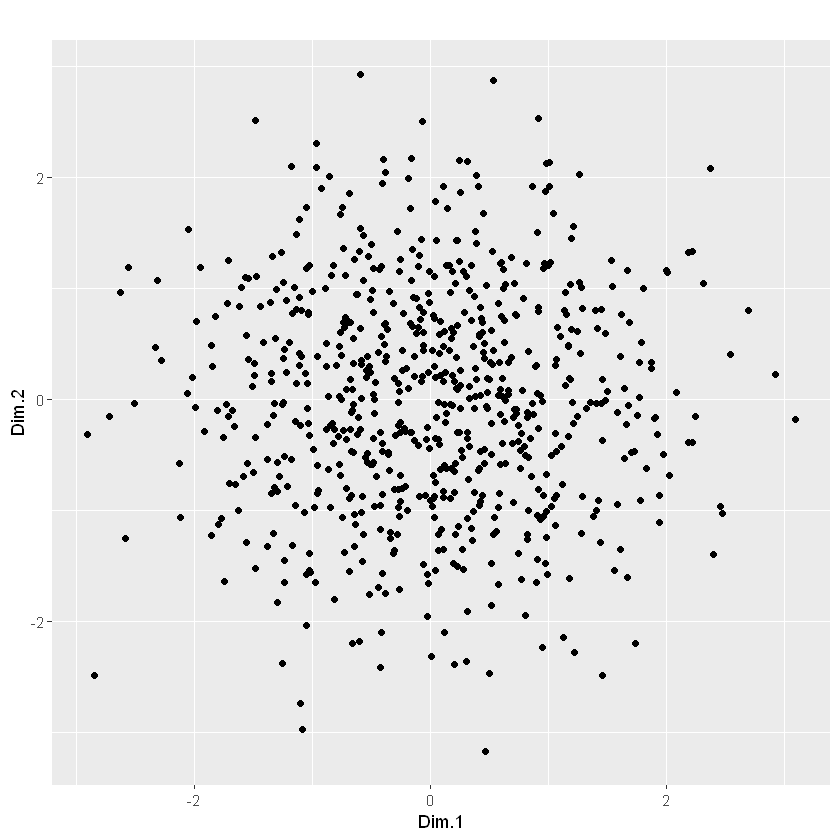

In [18]:
pca_unlabeled_pool <- princomp(unlabeled_pool[,-c("idx")], cor = TRUE, scores = TRUE)
pca_unlabeled_pool_components <- get_pca_ind(pca_unlabeled_pool)
p_unlabeled_pool <- ggplot(data = data.table(pca_unlabeled_pool_components$coord[,1:2]), aes(x = Dim.1, y = Dim.2)) +
                    geom_point() +
                    labs( title = "") 
p_unlabeled_pool


# Generate Test Set

In [19]:
if(GenerateTTData == 1){
    test_set <- head(unlabeled_pool,test_ins)
    
    ################## Buraya variale'ların datatipine göre bir şeyler yazılabilir
    test_set$density                    = runif(test_ins, 10, 90) 
    test_set$`%-similar-wanted`         = runif(test_ins, 10, 90) 
    test_set$`budget-multiplier-dummy`  = runif(test_ins, 1, 10) 
    test_set$`density-multiplier-dummy` = runif(test_ins, 0.01, 1) 
    test_set$`noise-dummy`              = runif(test_ins, 0.00001, 0.0001) 
    test_set$`tick-limit`               = runif(test_ins, 90, 110) 
    
    test_set[,c("idx"):= NULL]
      
    print(paste0("ABM run start time : ",Sys.time()))
    test_set = run_ABM(nofrep,test_ins,test_set) %>% as.data.table()
    print(paste0("ABM run end time : ",Sys.time()))
    
    fwrite(test_set, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/test_set_",Sys.Date(),".csv"))
}else{
    test_set <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/test_set_04122019.csv")  
}

[1] "ABM run start time : 2019-12-20 09:29:58"
[1] "ABM run end time : 2019-12-20 09:36:00"


10 * 10 ~ 1 min
100 * 10 ~ 14 min
900 * 10 ~ 09:16 -- 2019-12-03 07:54:10 +03"

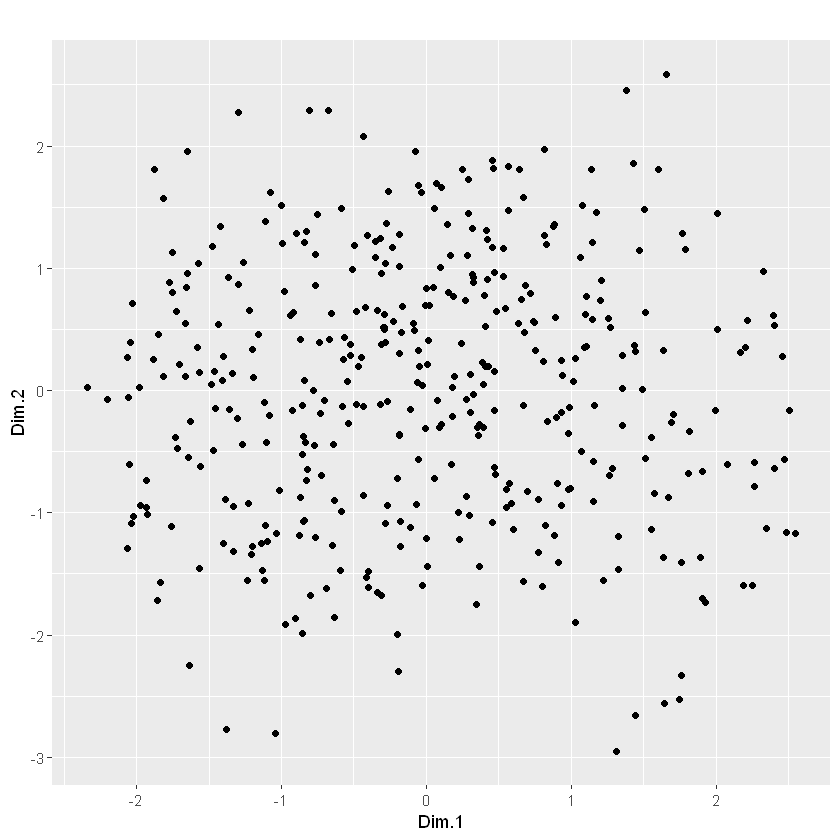

In [21]:
pca_test_set <- princomp(test_set, cor = TRUE, scores = TRUE)
pca_test_set_components <- get_pca_ind(pca_test_set)
p_test_set <- ggplot(data = data.table(pca_test_set_components$coord[,1:2]), aes(x = Dim.1, y = Dim.2)) +
                    geom_point() +
                    labs( title = "") 
p_test_set

# Benchmark : One-shot sampling, No feature elimination

## Generate Training Set

Select a very big data pool ( nofinstances should be very high ) , like 1000

In [23]:
if(GenerateTTData == 1){
    LHSample = as.data.table(maximinLHS(n = train_ins_oneshot, k = nofparams, dup = 5))
    
    LHSample$V1 = qunif(LHSample$V1, 10, 90) 
    LHSample$V2 = qunif(LHSample$V2, 10, 90) 
    LHSample$V3 = qunif(LHSample$V3, 1, 10) 
    LHSample$V4 = qunif(LHSample$V4, 0.01, 1)    
    LHSample$V5 = qunif(LHSample$V5, 0.00001, 0.0001) 
    LHSample$V6 = qunif(LHSample$V6, 90, 110)  
    
    setnames(LHSample, c(paste0("V",1:nofparams)), feature_names)
   
    LHSample$output <- 0.00
    
    print(paste0("ABM run start time : ",Sys.time()))
    LHSample = run_ABM(nofrep,train_ins_oneshot,LHSample) %>% as.data.table()
    print(paste0("ABM run end time : ",Sys.time()))
    
    fwrite(LHSample, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Data",Sys.Date(),".csv"))
    
}else{
    LHSample <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Data_04122019.csv")
}

[1] "ABM run start time : 2019-12-20 09:37:14"
[1] "ABM run end time : 2019-12-20 09:44:53"


In [24]:
one_shot_data = copy(LHSample)

### Visualization

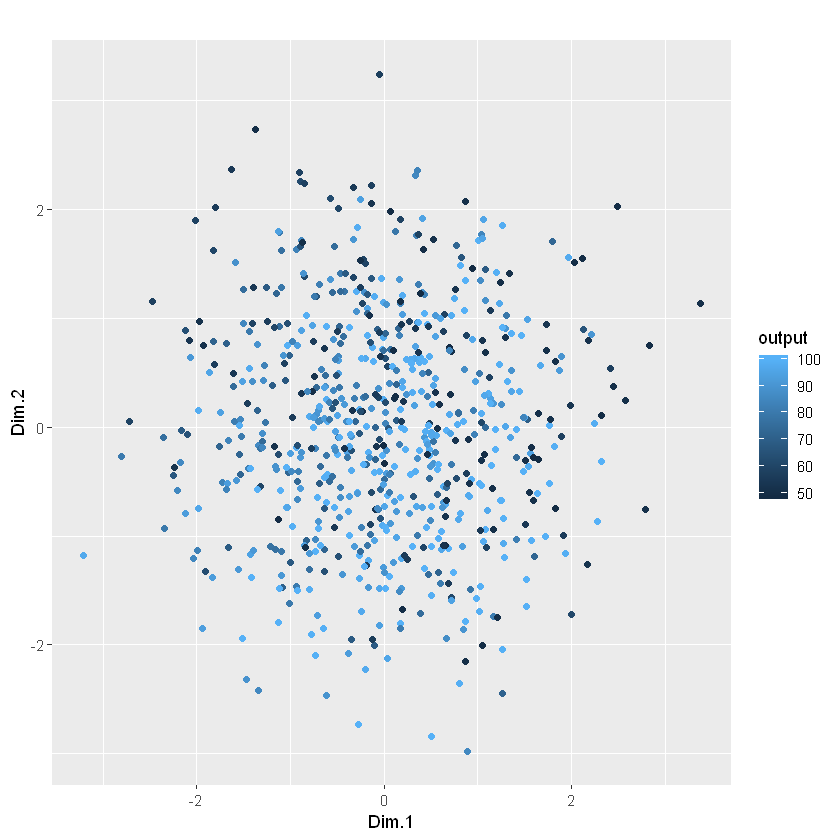

In [26]:
pca_LHSample <- princomp(LHSample[,.SD, .SDcols = !c("output")], cor = TRUE, scores = TRUE)

#fviz_pca_ind(pca_LHSample,
#             col.ind = "cos2", # Color by the quality of representation
#             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
#              geom="point"
#             )

pca_LHSample_components <- get_pca_ind(pca_LHSample)
pca_LHSample_components <-cbind(pca_LHSample_components$coord[,1:2],LHSample[,.SD, .SDcols = c("output")])
p_LHSample <- ggplot(data = pca_LHSample_components, aes(x = Dim.1, y = Dim.2)) +
             geom_point(aes(colour = output)) +
             labs( title = "", legend = "output") 
p_LHSample

## Train & Test Metamodel

In [27]:
model_oneshot <- randomForest(x = LHSample[, -c("output")], y = LHSample$output, importance = TRUE,ntree = ntree, mtry = mtry)
model_oneshot


Call:
 randomForest(x = LHSample[, -c("output")], y = LHSample$output,      ntree = ntree, mtry = mtry, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 400
No. of variables tried at each split: 2

          Mean of squared residuals: 29.47793
                    % Var explained: 90.3

In [28]:
obb_error_oneshot <- obb_error_func(model_oneshot)

In [ ]:
#OBB_pred = cbind(LHSample$output,model_oneshot$predicted)
#names(OBB_pred) <- c("actual","predicted")

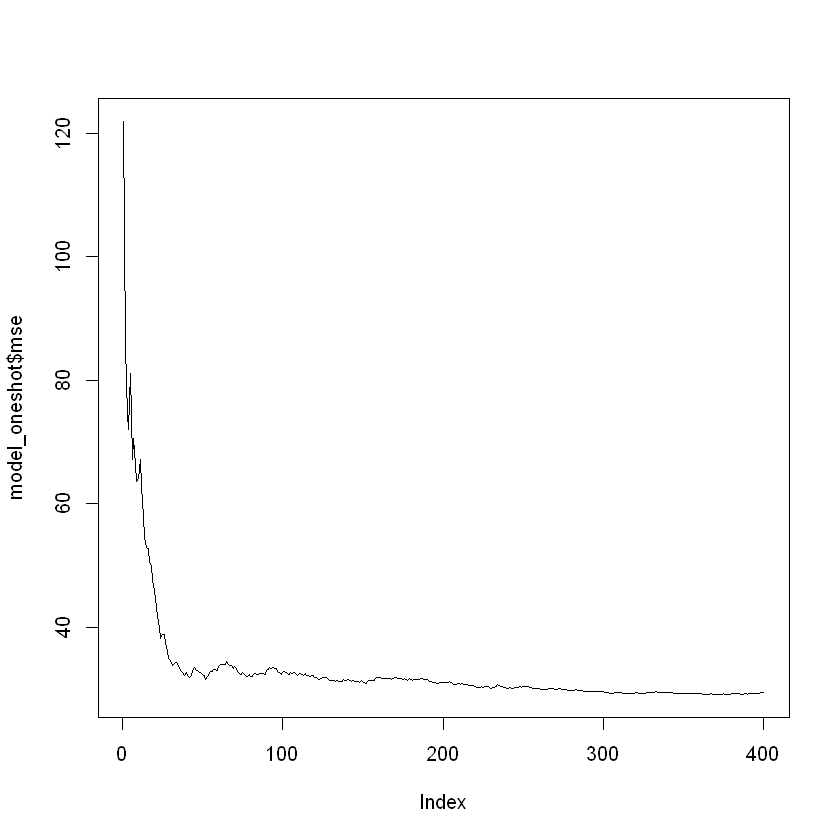

In [29]:
plot(model_oneshot$mse, type="l")

In [30]:
test_prediction_oneshot = get_test_predictions(model_oneshot,test_set,error_type)
predictedLabels_oneshot = test_prediction_oneshot[[1]]

performance_table_oneshot = data.table(iter = numeric(), mae= numeric(),rmse= numeric(), mape = numeric())

performance_table_temp = test_prediction_oneshot[[2]]
performance_table_oneshot = rbind(performance_table_oneshot,performance_table_temp, use.names = FALSE)
rm(performance_table_temp)   

output_variables = test_prediction_oneshot[[3]]    


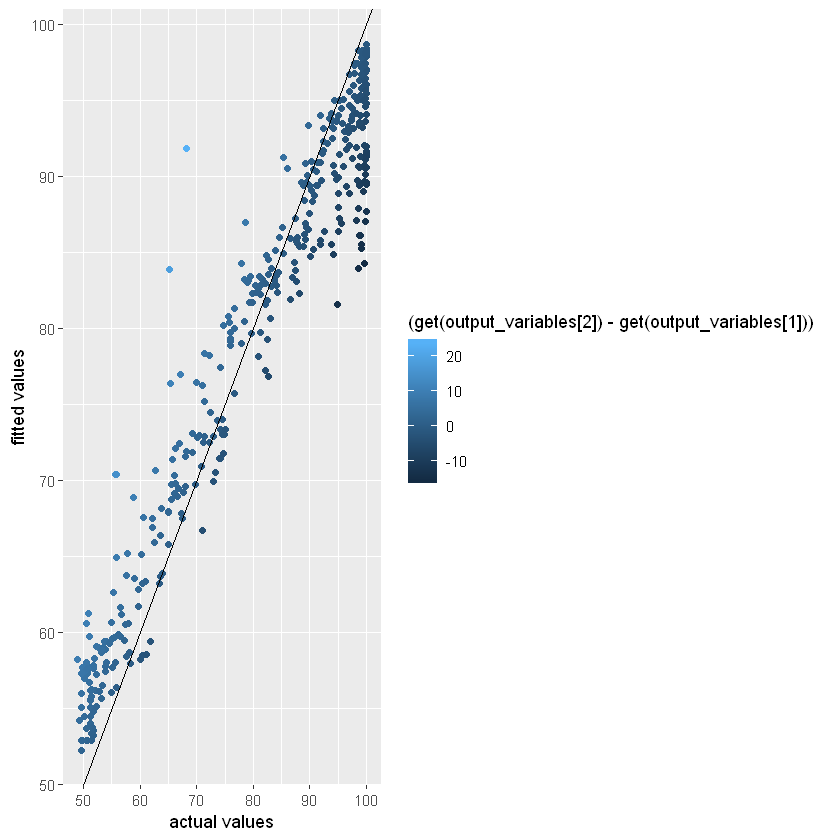

In [31]:
p_oneshot <- ggplot(predictedLabels_oneshot,aes(x = get(output_variables[1]), y = get(output_variables[2]), color = (get(output_variables[2]) - get(output_variables[1])))) +
            geom_point() +
            geom_abline() +
            xlab("actual values") +
            ylab("fitted values")

p_oneshot

# Random Sampling & No Feature Elimination

## Generate Training Set

Select a relatively big data pool ( nofinstances should be medium) , like 400

In [34]:
if(GenerateTTData == 1){
   
    LHSample_Ad = as.data.table(maximinLHS(n = train_ins_Ad, k = nofparams, dup = 5))
    
    LHSample_Ad$V1 = qunif(LHSample_Ad$V1, 10, 90) 
    LHSample_Ad$V2 = qunif(LHSample_Ad$V2, 10, 90)
    LHSample_Ad$V3 = qunif(LHSample_Ad$V3, 1, 10) 
    LHSample_Ad$V4 = qunif(LHSample_Ad$V4, 0.01, 1)    
    LHSample_Ad$V5 = qunif(LHSample_Ad$V5, 0.00001, 0.0001) 
    LHSample_Ad$V6 = qunif(LHSample_Ad$V6, 90, 110) 
    
    setnames(LHSample_Ad, c(paste0("V",1:nofparams)), feature_names)
    LHSample_Ad$output <- 0.00
    
    print(paste0("ABM run start time : ",Sys.time()))
    LHSample_Ad = run_ABM(nofrep,train_ins_Ad,LHSample_Ad) %>% as.data.table()
    print(paste0("ABM run end time : ",Sys.time()))
    
    fwrite(LHSample_Ad, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data",Sys.Date(),".csv"))

}else{
    LHSample_Ad <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data_04122019.csv")
}

[1] "ABM run start time : 2019-12-20 09:48:09"
[1] "ABM run end time : 2019-12-20 09:50:26"


In [35]:
adaptive_initial_data = copy(LHSample_Ad)

## Train & Test Metamodel

In [36]:
# Record train candidates
train_candidates_table = matrix(c(1:ncol(LHSample_Ad) ), nrow = 0, ncol = ncol(LHSample_Ad) )
colnames(train_candidates_table) <- colnames(LHSample_Ad)
colnames(train_candidates_table)[colnames(train_candidates_table) == "output"] <- "idx"

# Record model performances
performance_table = data.table(iter = numeric(), mae= numeric(),rmse= numeric(), mape = numeric()  )

#error_type = "mape"  
predictedLabels_table = copy(test_set)

In [37]:
iter = 1

while(iter < numiter){ 
    
    print(iter)

    trainx = LHSample_Ad[,.SD, .SDcols = feature_names]
    trainy = LHSample_Ad$output
    
    # Train the model
    model_Sub <- randomForest( x = trainx, y =  trainy,importance = TRUE,ntree = ntree, mtry = mtry)
    assign(paste0("model_Sub_",iter),model_Sub)
    
     if(iter == 1){ # keep just as info
         ranked_features = get_variable_importance(model_Sub)
     }                      
         
    
    if(iter == 1){
        obb_error <- as.data.table(obb_error_func(model_Sub)) 
        obb_error$iter <- 1 
        setnames(obb_error,"V1","obb_error")
    }else{
         ## OOB Error & Test Error 
        obb_error_Sub <- as.data.table(obb_error_func(model_Sub)) 
        obb_error_Sub$iter <- iter 
        obb_error <- rbind(obb_error,obb_error_Sub, use.names = FALSE)
        rm(obb_error_Sub)
    }
 
    # test the model on test set
    test_predictions_Sub = get_test_predictions(model_Sub,test_set,error_type)
    predictedLabels_Sub = test_predictions_Sub[[1]]
    setnames(predictedLabels_Sub,c("pred_output",error_type), c(paste0("pred_output_",iter),paste0(error_type,"_",iter)))    
    predictedLabels_table = cbind(predictedLabels_table,predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_",iter),paste0(error_type,"_",iter))])
    
    # record the general test errors
    performance_table_temp = test_predictions_Sub[[2]]
    performance_table_temp[[1]] = iter
    performance_table = rbind(performance_table,performance_table_temp, use.names = FALSE)
    rm(performance_table_temp)   
    
    output_variables = test_predictions_Sub[[3]]          

    # Sample from unlabeled data
    unlabeled_set <- copy(unlabeled_pool)
    train_candidates = random_sample_selection(selected_ins,unlabeled_set)
    # Eliminate train candidates from the unlabeled pool
    unlabeled_pool = unlabeled_pool[- train_candidates$idx]
    rm(unlabeled_set)
    
    # Run ABM to label train candidates
#  train_candidates = as.data.table(train_candidates) 
    paste0("ABM train_candidate run start time : ",Sys.time())
    train_candidates = run_ABM(nofrep,selected_ins,train_candidates)
    paste0("ABM train_candidate run end time : ",Sys.time())
    
    if(iter == 1){
        train_candidates_table <- copy(train_candidates)
        train_candidates_table$iter <- iter
    }else{
        train_candidates_temp <- copy(train_candidates)
        train_candidates_temp$iter <- iter
        
        train_candidates_table <- rbindlist(list(train_candidates_table,train_candidates_temp), use.names=TRUE)
        rm(train_candidates_temp)
    }

    # Add new data to train data
    LHSample_Ad = rbind(LHSample_Ad,train_candidates[,-c("idx")])

    iter = iter + 1
}

# plot koy her iteration'da göstersin.
#setcolorder(data,variableorder) ################# bunu bi yerlere koyman gerekebilir, dikkat!!


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9


In [38]:
# Final records
FinalTrainData_Rd = copy(LHSample_Ad)
performance_table_Rd = copy(performance_table)
train_candidates_table_Rd  = copy(train_candidates_table)
predictedLabels_table_Rd = copy(predictedLabels_table)
obb_error_Rd = copy(obb_error)

In [39]:
# show results
nrow(FinalTrainData_Rd)
performance_table_Rd 
train_candidates_table_Rd  
head(predictedLabels_table_Rd)
obb_error_Rd

[1] 245

iter,mae,rmse,mape
<dbl>,<dbl>,<dbl>,<dbl>
1,6.291519,7.841760,8.841208
2,6.335307,7.953274,8.928276
3,6.205703,7.740418,8.679382
4,6.288596,8.017836,8.875839
5,6.317495,8.001207,8.847310
6,6.083180,7.670087,8.463658
7,5.862838,7.405753,8.200228
8,6.210699,7.889548,8.719571
9,6.040424,7.739631,8.465459


density,%-similar-wanted,budget-multiplier-dummy,density-multiplier-dummy,noise-dummy,tick-limit,idx,output,iter
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
72.44172,72.98883,3.616621,0.27565631,5.339539e-05,107.93101,169,99.96838,1
80.02325,29.29841,5.109416,0.88015383,5.261599e-05,100.26068,203,72.85066,1
82.73710,24.24204,7.310549,0.34468246,3.728506e-05,104.36580,254,59.71393,1
54.31753,19.00496,9.117432,0.90169032,2.125501e-05,108.20355,487,58.17454,1
86.68350,21.00685,7.707449,0.51560132,1.995261e-05,99.25120,490,56.75368,1
73.17690,64.44834,4.250951,0.85338974,3.975319e-05,104.56023,13,98.53800,2
25.87072,71.93649,7.551367,0.59146457,2.936624e-05,101.52524,114,100.00000,2
87.06451,29.96296,2.746519,0.12427393,9.421870e-05,108.18142,444,74.15641,2
67.66227,42.67276,7.066681,0.87167987,4.496824e-05,109.97553,531,86.31692,2


density,%-similar-wanted,budget-multiplier-dummy,density-multiplier-dummy,noise-dummy,tick-limit,output,pred_output_1,RMSE_1,pred_output_2,...,pred_output_5,RMSE_5,pred_output_6,RMSE_6,pred_output_7,RMSE_7,pred_output_8,RMSE_8,pred_output_9,RMSE_9
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
89.80781,63.22101,9.559364,0.7183232,9.772682e-05,94.85461,98.62087,80.66245,17.958421,78.75847,...,78.83793,19.782938,77.75237,20.868500,81.11030,17.510569,79.87838,18.742488,77.67927,20.941598
65.95304,27.51730,1.113979,0.4611830,4.533282e-05,91.35383,66.09090,74.70719,8.616290,75.54323,...,73.46857,7.377670,73.89223,7.801331,72.66571,6.574810,75.15347,9.062575,72.98141,6.890518
65.63748,42.72006,7.460221,0.2498248,4.748342e-05,106.60832,86.53810,89.83889,3.300789,89.86361,...,89.31337,2.775271,89.30619,2.768085,89.05033,2.512234,89.13834,2.600240,89.43755,2.899446
49.08474,53.36187,1.029111,0.3209241,2.648540e-05,95.31602,97.06720,92.53078,4.536418,90.83740,...,90.95209,6.115109,92.19373,4.873470,91.59741,5.469785,91.87484,5.192353,92.66884,4.398354
82.31666,32.86349,9.937437,0.7424780,9.336225e-05,91.00066,73.99356,72.20164,1.791921,73.37479,...,72.42276,1.570800,72.43687,1.556690,72.86920,1.124364,72.65812,1.335442,72.89494,1.098620
59.08719,22.26741,5.281372,0.7351098,1.573031e-05,98.78114,63.67668,70.27061,6.593935,68.90321,...,66.78620,3.109520,66.40192,2.725243,66.44336,2.766685,65.60483,1.928153,65.77978,2.103105


obb_error,iter
<dbl>,<dbl>
67.75845,1
70.72702,2
65.96399,3
66.29503,4
65.65416,5
60.61544,6
58.30798,7
63.18628,8
59.99245,9


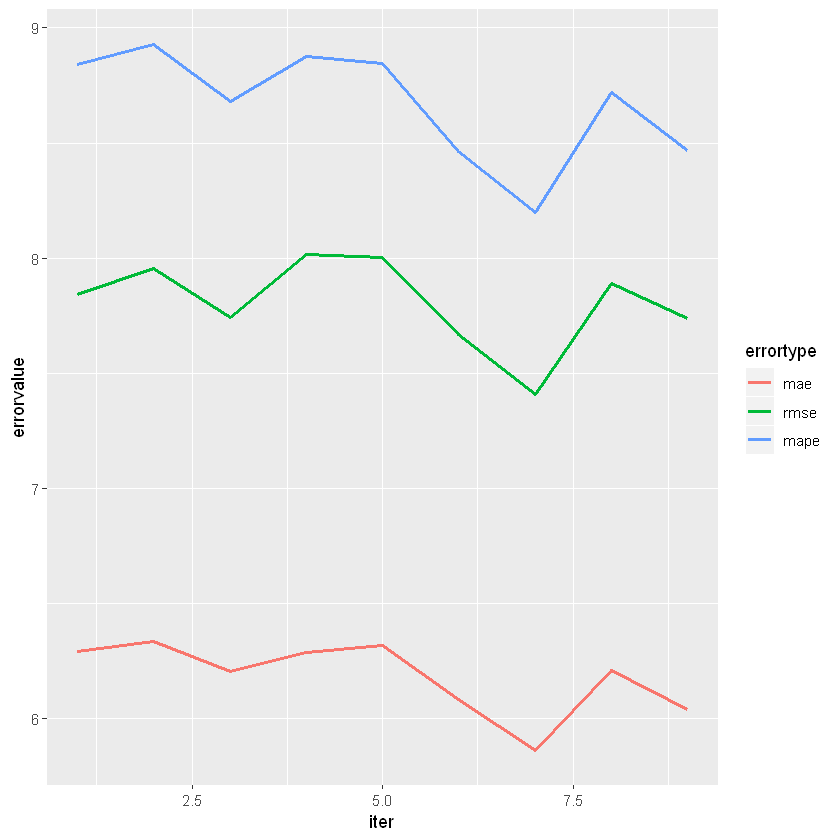

In [45]:
performance_molten_Rd <- melt(data = performance_table_Rd
                             , id.vars = 'iter')
setnames(performance_molten_Rd, c("variable","value"),c("errortype","errorvalue"))
p_Rd = ggplot(performance_molten_Rd, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
          geom_line(lwd=1)
p_Rd

# Adaptive Sampling & No Feature Elimination

## Generate Training Set

Select a relatively big data pool ( nofinstances should be medium) , like 400

In [40]:
LHSample_Ad = copy(adaptive_initial_data)

In [ ]:
#if(GenerateTTData == 1){
#   
#    LHSample_Ad = as.data.table(maximinLHS(n = train_ins_Ad, k = nofparams, dup = 5))
#    
#    LHSample_Ad$V1 = qunif(LHSample_Ad$V1, 10, 90) 
#    LHSample_Ad$V2 = qunif(LHSample_Ad$V2, 10, 90) 
#    setnames(LHSample_Ad, c("V1","V2"), feature_names)
#    LHSample_Ad$output <- 0.00
#    
#    paste0("ABM run start time : ",Sys.time())
#    LHSample_Ad = run_ABM(nofrep,train_ins_Ad,LHSample_Ad) %>% as.data.table()
#    paste0("ABM run end time : ",Sys.time())
#    
#    fwrite(LHSample_Ad, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data",Sys.Date(),".csv"))
#
#}else{
#    LHSample_Ad <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data_04122019.csv")
#    LHSample_Ad <- head(LHSample_Ad[`%-similar-wanted` < 90],300)
#
#}

### Visualization

In [ ]:
pca_LHSample_Ad <- princomp(LHSample_Ad[,-c("output")], cor = TRUE, scores = TRUE)

In [ ]:
#fviz_pca_ind(pca_LHSample,
#             col.ind = "cos2", # Color by the quality of representation
#             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
#              geom="point"
#             )

pca_LHSample_Ad_components <- get_pca_ind(pca_LHSample_Ad)
pca_LHSample_Ad_components <-cbind(pca_LHSample_Ad_components$coord[,1:2],LHSample_Ad[,c("output")])
p_LHSample_Ad <- ggplot(data = pca_LHSample_Ad_components, aes(x = Dim.1, y = Dim.2)) +
                     geom_point(aes(colour = output)) +
                     labs( title = "", legend = "output") 
p_LHSample_Ad

## Train & Test Metamodel

In [41]:
# Record train candidates
train_candidates_table = matrix(c(1:ncol(LHSample_Ad) ), nrow = 0, ncol = ncol(LHSample_Ad) )
colnames(train_candidates_table) <- colnames(LHSample_Ad)
colnames(train_candidates_table)[colnames(train_candidates_table) == "output"] <- "idx"

# Record model performances
performance_table = data.table(iter = numeric(), mae= numeric(),rmse= numeric(), mape = numeric()  )

#error_type = "mape"  
predictedLabels_table = copy(test_set)

In [42]:

iter = 1

while(iter < numiter){ 
    
    print(iter)

    trainx = LHSample_Ad[,.SD, .SDcols = feature_names]
    trainy = LHSample_Ad$output
    
    # Train the model
    model_Sub <- randomForest( x = trainx, y =  trainy,importance = TRUE,ntree = ntree, mtry = mtry)
    assign(paste0("model_Sub_",iter),model_Sub)
    
     if(iter == 1){ # keep just as info
         ranked_features = get_variable_importance(model_Sub)
     }                      
         
    
    if(iter == 1){
        obb_error <- as.data.table(obb_error_func(model_Sub)) 
        obb_error$iter <- 1 
        setnames(obb_error,"V1","obb_error")
    }else{
         ## OOB Error & Test Error 
        obb_error_Sub <- as.data.table(obb_error_func(model_Sub)) 
        obb_error_Sub$iter <- iter 
        obb_error <- rbind(obb_error,obb_error_Sub, use.names = FALSE)
        rm(obb_error_Sub)
    }
 
    # test the model on test set
    test_predictions_Sub = get_test_predictions(model_Sub,test_set,error_type)
    predictedLabels_Sub = test_predictions_Sub[[1]]
    setnames(predictedLabels_Sub,c("pred_output",error_type), c(paste0("pred_output_",iter),paste0(error_type,"_",iter)))    
    predictedLabels_table = cbind(predictedLabels_table,predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_",iter),paste0(error_type,"_",iter))])
    
    # record the general test errors
    performance_table_temp = test_predictions_Sub[[2]]
    performance_table_temp[[1]] = iter
    performance_table = rbind(performance_table,performance_table_temp, use.names = FALSE)
    rm(performance_table_temp)   
    
    output_variables = test_predictions_Sub[[3]]          

    # Sample from unlabeled data
    unlabeled_set <- copy(unlabeled_pool)
    train_candidates = sample_selection(selected_ins,unlabeled_set,trainx,trainy)
    # Eliminate train candidates from the unlabeled pool
    unlabeled_pool = unlabeled_pool[- train_candidates$idx]
    rm(unlabeled_set)
    
    # Run ABM to label train candidates
#  train_candidates = as.data.table(train_candidates) 
    paste0("ABM train_candidate run start time : ",Sys.time())
    train_candidates = run_ABM(nofrep,selected_ins,train_candidates)
    paste0("ABM train_candidate run end time : ",Sys.time())
    
    if(iter == 1){
        train_candidates_table <- copy(train_candidates)
        train_candidates_table$iter <- iter
    }else{
        train_candidates_temp <- copy(train_candidates)
        train_candidates_temp$iter <- iter
        
        train_candidates_table <- rbindlist(list(train_candidates_table,train_candidates_temp), use.names=TRUE)
        rm(train_candidates_temp)
    }

    # Add new data to train data
    LHSample_Ad = rbind(LHSample_Ad,train_candidates[,-c("idx")])

    iter = iter + 1
}

# plot koy her iteration'da göstersin.
#setcolorder(data,variableorder) ################# bunu bi yerlere koyman gerekebilir, dikkat!!


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9


In [43]:
# Final records
FinalTrainData_Ad = copy(LHSample_Ad)
performance_table_Ad = copy(performance_table)
train_candidates_table_Ad  = copy(train_candidates_table)
predictedLabels_table_Ad = copy(predictedLabels_table)
obb_error_Ad = copy(obb_error)

In [44]:
nrow(FinalTrainData_Ad)
performance_table_Ad
train_candidates_table_Ad
head(predictedLabels_table_Ad)
obb_error_Ad

[1] 245

iter,mae,rmse,mape
<dbl>,<dbl>,<dbl>,<dbl>
1,6.473998,8.051400,9.117176
2,6.010476,7.372467,8.469914
3,5.822460,7.068299,8.185086
4,5.732522,6.923471,8.067059
5,5.646021,6.827035,7.982707
6,5.324718,6.491564,7.533510
7,5.482723,6.638891,7.659495
8,5.266617,6.400851,7.340456
9,5.310154,6.470364,7.425208


density,%-similar-wanted,budget-multiplier-dummy,density-multiplier-dummy,noise-dummy,tick-limit,idx,output,iter
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
13.16295,81.92370,4.918442,0.90748670,5.156864e-05,108.65117,326,100.00000,1
10.41457,89.91221,1.036082,0.57597604,7.662668e-05,109.04119,635,100.00000,1
13.37395,88.40317,3.449100,0.07868366,8.048873e-05,108.15717,506,100.00000,1
44.57960,74.76277,5.121159,0.99222654,4.274789e-05,106.00483,311,99.92818,1
59.26529,75.16035,2.470868,0.39089915,3.816702e-05,105.17168,57,56.06910,1
66.01900,88.67981,1.050862,0.05744754,9.129029e-05,109.94240,627,49.36024,2
56.28091,82.52071,2.074132,0.06706306,5.985505e-05,92.17322,544,52.52708,2
34.11864,89.13136,1.133751,0.34217479,2.966778e-05,107.82599,364,52.83168,2
54.74058,75.14188,3.014332,0.33424647,8.527155e-05,107.89151,129,56.09169,2


density,%-similar-wanted,budget-multiplier-dummy,density-multiplier-dummy,noise-dummy,tick-limit,output,pred_output_1,RMSE_1,pred_output_2,...,pred_output_5,RMSE_5,pred_output_6,RMSE_6,pred_output_7,RMSE_7,pred_output_8,RMSE_8,pred_output_9,RMSE_9
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
89.80781,63.22101,9.559364,0.7183232,9.772682e-05,94.85461,98.62087,78.35281,20.268062,78.96059,...,81.47461,17.146256,83.49891,15.121954,84.52328,14.097588,84.56667,14.0541979,82.68739,15.933478
65.95304,27.51730,1.113979,0.4611830,4.533282e-05,91.35383,66.09090,76.09316,10.002260,75.18056,...,75.48555,9.394654,74.45856,8.367660,74.33545,8.244557,74.13676,8.0458589,74.20070,8.109802
65.63748,42.72006,7.460221,0.2498248,4.748342e-05,106.60832,86.53810,89.33985,2.801754,89.82723,...,89.48956,2.951463,89.25989,2.721792,89.73851,3.200407,89.86278,3.3246804,89.43928,2.901177
49.08474,53.36187,1.029111,0.3209241,2.648540e-05,95.31602,97.06720,91.93041,5.136791,91.98127,...,90.85816,6.209038,92.24697,4.820225,89.19557,7.871626,90.38601,6.6811927,89.22773,7.839467
82.31666,32.86349,9.937437,0.7424780,9.336225e-05,91.00066,73.99356,72.78441,1.209153,72.06061,...,72.70397,1.289594,72.49009,1.503473,72.39703,1.596530,73.70981,0.2837503,72.76296,1.230604
59.08719,22.26741,5.281372,0.7351098,1.573031e-05,98.78114,63.67668,70.93045,7.253769,69.94231,...,71.16496,7.488280,70.58823,6.911551,71.88659,8.209909,71.11941,7.4427329,70.24052,6.563844


obb_error,iter
<dbl>,<dbl>
69.89621,1
68.99560,2
69.56955,3
66.64179,4
68.72637,5
62.23706,6
65.13324,7
61.09306,8
60.82295,9


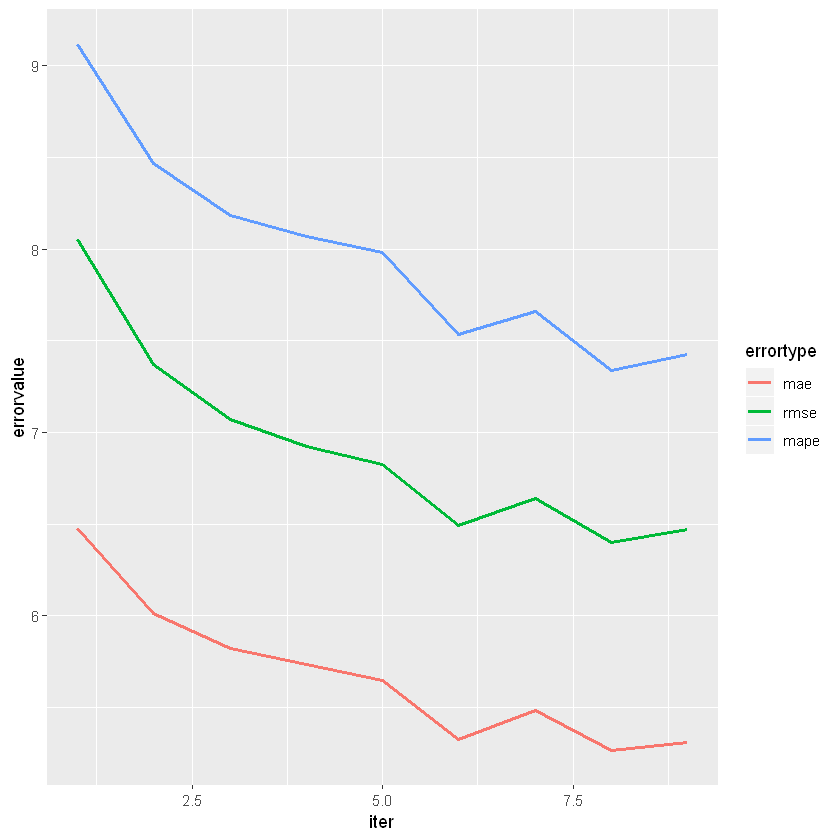

In [46]:
performance_molten_Ad <- melt(data = performance_table_Ad
                             , id.vars = 'iter')
setnames(performance_molten_Ad, c("variable","value"),c("errortype","errorvalue"))
p_Ad = ggplot(performance_molten_Ad, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
            geom_line(lwd=1)
p_Ad

# Random Sampling vs Uncertainty Sampling

In [52]:
require(gridExtra)

Loading required package: gridExtra

Attaching package: 'gridExtra'

The following object is masked from 'package:randomForest':

    combine

The following object is masked from 'package:dplyr':

    combine



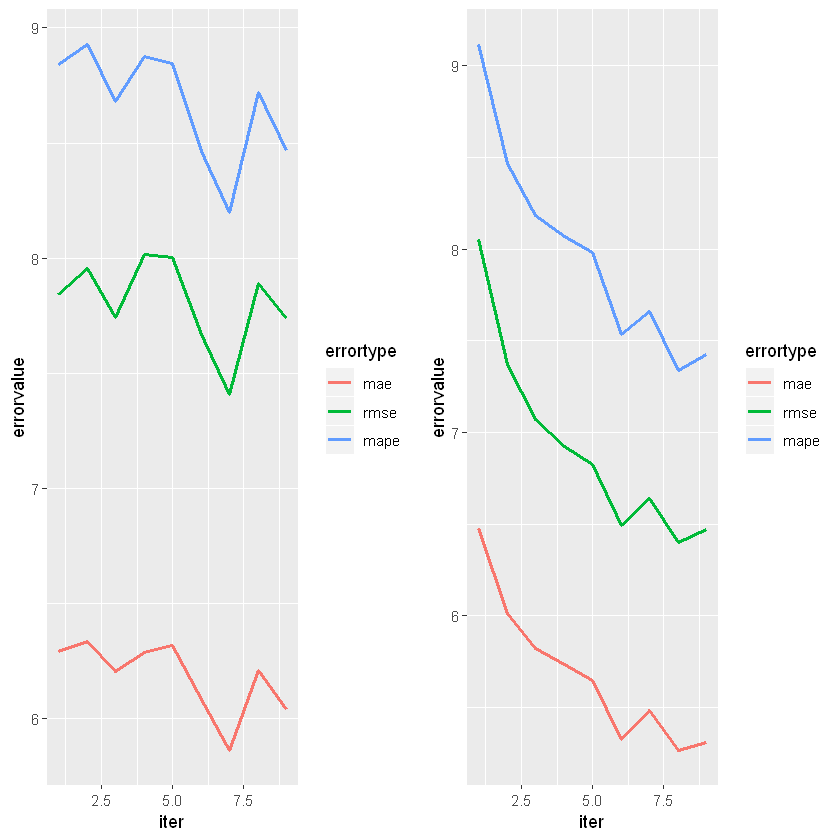

In [53]:
grid.arrange(p_Rd, p_Ad, ncol=2)

# Adaptive Sampling & Feature Elimination 

## Generate Training Set

Select a relatively big data pool ( nofinstances should be medium) , like 400

In [127]:
LHSample_Ad = copy(adaptive_initial_data)

In [ ]:
#if(GenerateTTData == 1){
#   
#    LHSample_Ad = as.data.table(maximinLHS(n = train_ins_Ad, k = nofparams, dup = 5))
#    
#    LHSample_Ad$V1 = qunif(LHSample_Ad$V1, 10, 90) 
#    LHSample_Ad$V2 = qunif(LHSample_Ad$V2, 10, 90) 
#    setnames(LHSample_Ad, c("V1","V2"), feature_names)
#    LHSample_Ad$output <- 0.00
#    
#    paste0("ABM run start time : ",Sys.time())
#    LHSample_Ad = run_ABM(nofrep,train_ins_Ad,LHSample_Ad) %>% as.data.table()
#    paste0("ABM run end time : ",Sys.time())
#    
#    fwrite(LHSample_Ad, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data",Sys.Date(),".csv"))
#
#}else{
#    LHSample_Ad <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data_04122019.csv")
#    LHSample_Ad <- head(LHSample_Ad[`%-similar-wanted` < 90],300)
#
#}

### Visualization

In [ ]:
pca_LHSample_Ad <- princomp(LHSample_Ad[,-c("output")], cor = TRUE, scores = TRUE)

In [ ]:
#fviz_pca_ind(pca_LHSample,
#             col.ind = "cos2", # Color by the quality of representation
#             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
#              geom="point"
#             )

pca_LHSample_Ad_components <- get_pca_ind(pca_LHSample_Ad)
pca_LHSample_Ad_components <-cbind(pca_LHSample_Ad_components$coord[,1:2],LHSample_Ad[,c("output")])
p_LHSample_Ad <- ggplot(data = pca_LHSample_Ad_components, aes(x = Dim.1, y = Dim.2)) +
                     geom_point(aes(colour = output)) +
                     labs( title = "", legend = "output") 
p_LHSample_Ad

## Train and Test Metamodel

In [128]:
# Record train candidates
train_candidates_table = matrix(c(1:ncol(LHSample_Ad) ), nrow = 0, ncol = ncol(LHSample_Ad) )
colnames(train_candidates_table) <- colnames(LHSample_Ad)
colnames(train_candidates_table)[colnames(train_candidates_table) == "output"] <- "idx"

# Record model performances
performance_table = data.table(iter = numeric(), mae= numeric(),rmse= numeric(), mape = numeric()  )


In [108]:
ranked_features

[1] "%-similar-wanted"         "density"                 
[3] "noise-dummy"              "tick-limit"              
[5] "density-multiplier-dummy" "budget-multiplier-dummy"

In [129]:
#error_type = "mape"  
predictedLabels_table_AdFe = copy(test_set)

loop = 0
iter = 1
columns_left = feature_names
nofEliminatedVariables <- 0 # initial

while(nofEliminatedVariables < nofparams & iter < numiter ){ # 1 is reponse v., another 1 is the last feature
    
    print(iter)
    loop =  loop + 1
    trainx = LHSample_Ad[,.SD, .SDcols = columns_left]
    trainy = LHSample_Ad$output
    
    # Train the model
    model_Sub <- randomForest( x = trainx, y =  trainy,importance = TRUE,ntree = ntree, mtry = mtry)
    assign(paste0("model_Sub_",iter),model_Sub)
    
     if(iter == 1){
  #      importances <- importance(model_Sub, type = 1, scale = FALSE)
  #      selected.vars <- order(importances, decreasing = TRUE)
  #      ranked_features = feature_names[selected.vars]
         ranked_features = get_variable_importance(model_Sub)
     }                      
         
    
    if(iter == 1){
        obb_error <- as.data.table(obb_error_func(model_Sub)) 
        obb_error$iter <- 1 
        setnames(obb_error,"V1","obb_error")
    }else{
         ## OOB Error & Test Error 
        obb_error_Sub <- as.data.table(obb_error_func(model_Sub)) 
        obb_error_Sub$iter <- iter 
        obb_error <- rbind(obb_error,obb_error_Sub, use.names = FALSE)
        rm(obb_error_Sub)
    }
 

    
 #  ## OOB Error & Test Error 
 #  obb_error_Sub <- as.data.table(obb_error(model_Sub)) 
 #  obb_error_Sub$iter <- iter 
 #  obb_error_AdFe <- rbind(obb_error_AdFe,obb_error_Sub, use.names = FALSE)
 #  rm(obb_error_Sub)
  
    # test the model on test set
    test_predictions_Sub = get_test_predictions(model_Sub,test_set,error_type)
    predictedLabels_Sub = test_predictions_Sub[[1]]
    setnames(predictedLabels_Sub,c("pred_output",error_type), c(paste0("pred_output_",iter),paste0(error_type,"_",iter)))  
    predictedLabels_table_AdFe = cbind(predictedLabels_table_AdFe,predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_",iter),paste0(error_type,"_",iter))])
    
    # record the general test errors
    performance_table_temp = test_predictions_Sub[[2]]
    performance_table_temp[[1]] = iter
    performance_table = rbind(performance_table,performance_table_temp, use.names = FALSE)
    rm(performance_table_temp)   
    
    output_variables = test_predictions_Sub[[3]]          

     # Sample from unlabeled data
    unlabeled_set <- copy(unlabeled_pool)
    train_candidates = sample_selection(selected_ins,unlabeled_set,trainx,trainy)
    # Eliminate train candidates from the unlabeled pool
    unlabeled_pool = unlabeled_pool[- train_candidates$idx]
    rm(unlabeled_set)
    # Run ABM to label train candidates
#  train_candidates = as.data.table(train_candidates) 
    paste0("ABM train_candidate run start time : ",Sys.time())
    train_candidates = run_ABM(nofrep,selected_ins,train_candidates)
    paste0("ABM train_candidate run end time : ",Sys.time())
    
    # Add new data to train data
    LHSample_Ad = rbind(LHSample_Ad,train_candidates[,-c("idx")])
    
if(nofEliminatedVariables < (nofparams - 1) ){ # 1 for output , 
            
    # order columns according to importances
    id_variables = colnames(select(LHSample_Ad, -starts_with("pred_"))) # pred_ouput is always at the end
    LHSample_Ad = setcolorder(LHSample_Ad[,.SD, .SDcols = id_variables],ranked_features)
    
    # Apply feature elimination
    feature_elimination_result = feature_elimination(h,nofEliminatedVariables,LHSample_Ad,ranked_features)

    columns_left_iter = feature_elimination_result[[1]]# 
    eliminated_columns = setdiff(columns_left,columns_left_iter) ## bunu historik tut
    columns_left = copy(columns_left_iter)
    rm(columns_left_iter)
    
    nofEliminatedVariables = as.numeric(feature_elimination_result[2])                  

    
#   setcolorder(LHSample_Ad,selected.vars)
#    feature_elimination_result = feature_elimination(h,nofEliminatedVariables,LHSample_Ad,selected.vars)
    iter = iter + 1
    loop = loop + 1
  }
    
#   if(loop > iter ){ break }   
}

# plot koy her iteration'da göstersin.
#setcolorder(data,variableorder) ################# bunu bi yerlere koyman gerekebilir, dikkat!!

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6
[1] 6


ERROR: Error in predict.randomForest(rf, unlabeled_set, predict.all = TRUE): newdata has 0 rows


In [50]:
# Final records
FinalTrainData_AdFe = copy(LHSample_Ad)
performance_table_AdFe = copy(performance_table)
train_candidates_table_AdFe  = copy(train_candidates_table)
predictedLabels_table_AdFe = copy(predictedLabels_table)
obb_error_AdFe = copy(obb_error)

In [51]:
nrow(FinalTrainData_AdFe)
performance_table_AdFe
train_candidates_table_AdFe
head(predictedLabels_table_AdFe)
obb_error_AdFe

[1] 210

iter,mae,rmse,mape
<dbl>,<dbl>,<dbl>,<dbl>
1,6.275319,7.784578,8.812498
2,6.040740,9.631544,8.663305


density,%-similar-wanted,budget-multiplier-dummy,density-multiplier-dummy,noise-dummy,tick-limit,idx,output,iter
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
49.90584,75.01995,7.645617,0.54757642,7.311075e-05,104.21166,140,65.60240,1
76.30828,64.27350,8.800393,0.29069505,3.300021e-05,108.87203,192,98.78165,1
50.40119,66.54958,1.710772,0.34678774,5.129994e-05,109.54256,540,99.25029,1
46.82448,75.41933,3.675221,0.36221238,7.882518e-05,100.95472,17,65.14403,1
65.45693,81.72564,2.350712,0.59976302,6.169758e-05,90.92102,458,51.18063,1
55.49370,89.49027,6.655675,0.01826037,5.203562e-05,97.66010,563,50.58617,2
31.04869,84.71331,1.998367,0.14277711,2.764362e-05,98.63503,307,56.30746,2
87.16152,84.62849,6.498112,0.08645300,1.809380e-05,97.18913,440,49.77249,2
84.95888,85.01924,9.499964,0.13605858,3.362309e-05,90.59966,530,52.07240,2


density,%-similar-wanted,budget-multiplier-dummy,density-multiplier-dummy,noise-dummy,tick-limit,output,pred_output_1,RMSE_1,pred_output_2,...,pred_output_5,RMSE_5,pred_output_6,RMSE_6,pred_output_7,RMSE_7,pred_output_8,RMSE_8,pred_output_9,RMSE_9
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
89.80781,63.22101,9.559364,0.7183232,9.772682e-05,94.85461,98.62087,78.35281,20.268062,78.96059,...,81.47461,17.146256,83.49891,15.121954,84.52328,14.097588,84.56667,14.0541979,82.68739,15.933478
65.95304,27.51730,1.113979,0.4611830,4.533282e-05,91.35383,66.09090,76.09316,10.002260,75.18056,...,75.48555,9.394654,74.45856,8.367660,74.33545,8.244557,74.13676,8.0458589,74.20070,8.109802
65.63748,42.72006,7.460221,0.2498248,4.748342e-05,106.60832,86.53810,89.33985,2.801754,89.82723,...,89.48956,2.951463,89.25989,2.721792,89.73851,3.200407,89.86278,3.3246804,89.43928,2.901177
49.08474,53.36187,1.029111,0.3209241,2.648540e-05,95.31602,97.06720,91.93041,5.136791,91.98127,...,90.85816,6.209038,92.24697,4.820225,89.19557,7.871626,90.38601,6.6811927,89.22773,7.839467
82.31666,32.86349,9.937437,0.7424780,9.336225e-05,91.00066,73.99356,72.78441,1.209153,72.06061,...,72.70397,1.289594,72.49009,1.503473,72.39703,1.596530,73.70981,0.2837503,72.76296,1.230604
59.08719,22.26741,5.281372,0.7351098,1.573031e-05,98.78114,63.67668,70.93045,7.253769,69.94231,...,71.16496,7.488280,70.58823,6.911551,71.88659,8.209909,71.11941,7.4427329,70.24052,6.563844


obb_error,iter
<dbl>,<dbl>
68.47979,1
111.12935,2


In [ ]:
#varImpPlot(model_Ad)

In [ ]:
NLQuit()